In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
%load_ext autoreload
%autoreload 2

# Formatting your data: feature extraction from motion tracking output

In [3]:
# Create and run a project. Explore different processing parameters (smoothing, imputation)

In [4]:
my_deepof_project = deepof.data.Project(
                path=os.path.join("../../Desktop/deepOF_CSDS_tutorial_dataset/"),
                arena="circular-autodetect",
                animal_ids=["B", "W"],
                video_format=".mp4",
                exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"],
                video_scale=380,
                enable_iterative_imputation=True,
                exp_conditions={
                    '20191204_Day2_SI_JB08_Test_56': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_61': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_62': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_54': 'Nonstressed',
                    '20191204_Day2_SI_JB08_Test_63': 'Nonstressed',
                    '20191204_Day2_SI_JB08_Test_64': 'Nonstressed'
                }
)

# Set manually the edge in the polygons that we're measuring

In [5]:
# my_deepof_project = my_deepof_project.run()

In [6]:
# Save your project to avoid laborious repetitions

In [7]:
# my_deepof_project.save("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_coordinates")

In [8]:
# Load a previously saved project
my_deepof_project = deepof.data.load("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_coordinates_1667951748.pkl")

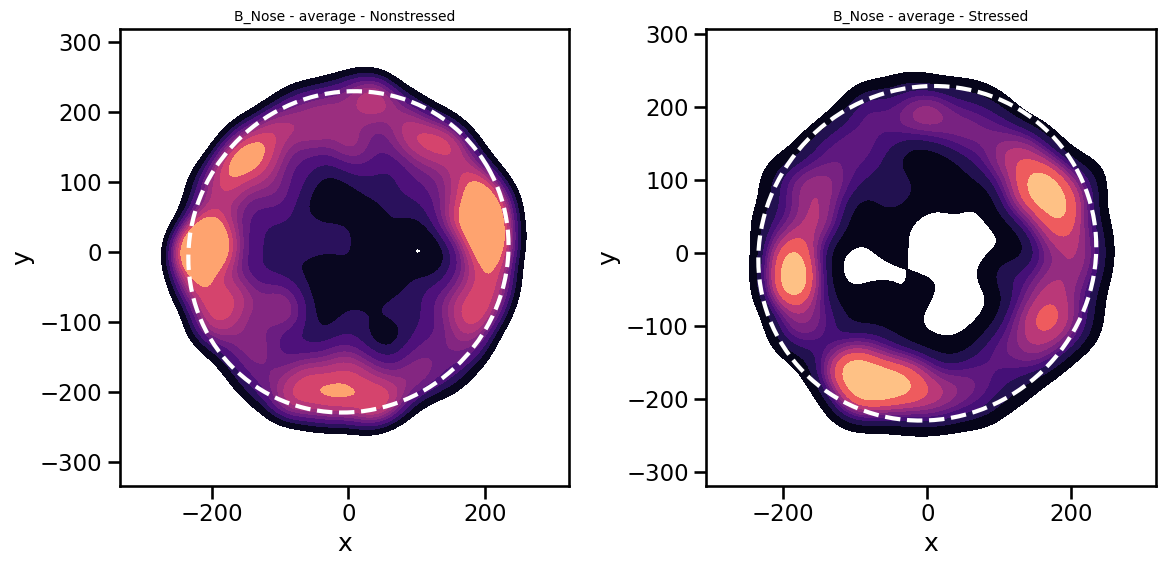

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import deepof.visuals
from matplotlib.patches import Ellipse

sns.set_context("talk")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="Nonstressed",
    ax=ax1,
    show=False,
    display_arena=True,
    experiment_id="average",
)

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="Stressed",
    ax=ax2,
    show=False,
    display_arena=True,
    experiment_id="average",
)

plt.tight_layout()
plt.show()

In [10]:
import pickle
import numpy as np
with open("../train_models/deepof_unsupervised_VQVAE_encodings_input=coords_k=100_latdim=8_kmeans_loss=0.0_run=1.pkl", "rb") as handle:
    vqvae_solution = pickle.load(handle)

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from deepof.post_hoc import get_transitions
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm_notebook as tqdm


def merge_and_smooth_clusters(
    n_clusters, centroids, embedding, concat_embedding, cluster_assignments
):
    """Merges the current clusters using a hierarchical agglomerative approach, and smoothens using a Gaussian HMM.

    Args:
        n_clusters (int): number of clusters to report.
        centroids (np.ndarray): precomputed means per cluster.
        embedding (tabdict): original deepof.TableDict object containing unsupervised embeddings.
        concat_embedding (np.ndarray): concatenated list of embeddings per animal in the dataset.
        cluster_assignments (tabdict): original deepof.TableDict object containing cluster assignments.

    Returns:
        new_soft_assignments (np.ndarray): concatenated postprocessed assignments for all animals in the dataset.
    """

    # Merge clusters ussing a hierarchical agglomerative approach
    new_hard_assignments = AgglomerativeClustering(
        n_clusters=n_clusters, compute_distances=True
    ).fit_predict(centroids)
    cluster_predictor = LinearDiscriminantAnalysis().fit(
        centroids, new_hard_assignments
    )
    centroids = cluster_predictor.means_
    new_soft_assignments = cluster_predictor.predict_proba(concat_embedding)

    # Rebuild the soft assignments dictionary per experimental animal
    new_soft_assignments = np.split(
        new_soft_assignments,
        np.cumsum([i.shape[0] for i in embedding.values()]),
    )
    new_soft_assignments = {
        key: val for key, val in zip(cluster_assignments.keys(), new_soft_assignments)
    }

    # Smooth assignments across time using a Gaussian HMM on the embeddings, with priors based on the clustering results
    for key, val in tqdm(new_soft_assignments.items()):

        hmm = GaussianHMM(
            startprob_prior=np.unique(val.argmax(axis=1), return_counts=True)[1],
            transmat_prior=get_transitions(val.argmax(axis=1), n_states=n_clusters) + 10,
            means_prior=centroids,
            n_components=n_clusters,
            covariance_type="diag",
            n_iter=100,
            tol=0.0001,
        )
        
        hmm.fit(embedding[key].numpy())
        new_soft_assignments[key] = hmm.predict_proba(embedding[key].numpy())

    return new_soft_assignments


def cluster_postprocessing(embedding, cluster_assignments, n_clusters="auto"):
    """Merges clusters using a hierarchical approach.

    Args:
        embedding (list): list of embeddings per animal in the dataset.
        cluster_assignments (list): list of cluster assignments per animal in the dataset.
        n_clusters (int): number of clusters to report.

    Returns:
        new_soft_assignments (list): list of new (merged) cluster assignments.

    """
    # Concatenate embeddings and cluster assignments in to unique np.ndarray objects
    concat_embedding = np.concatenate([tensor.numpy() for tensor in embedding.values()])
    hard_assignments = np.concatenate(
        [tensor.numpy().argmax(axis=1) for tensor in cluster_assignments.values()]
    )

    assert concat_embedding.shape[0] == hard_assignments.shape[0]

    # Get cluster centroids from the concatenated embeddings
    centroids = []
    for cluster in range(np.max(hard_assignments)):
        centroid = concat_embedding[hard_assignments == cluster]
        if len(centroid) == 0:
            continue
        centroid = np.mean(centroid, axis=0)
        centroids.append(centroid)

    centroids = np.stack(centroids)

    # Merge centroids using a hierarchical approach with the given resolution, and soft-assign instances to clusters
    if isinstance(n_clusters, int):
        new_soft_assignments = merge_and_smooth_clusters(
            n_clusters, centroids, embedding, concat_embedding, cluster_assignments
        )

    else:
        raise NotImplementedError

    return new_soft_assignments

In [ ]:
from hmmlearn.hmm import GaussianHMM

new_ass = cluster_postprocessing(
    vqvae_solution[0], 
    vqvae_solution[1],
    n_clusters=12
)
hcc = new_ass['20191203_Day1_SI_JB08_Test_54'].argmax(axis=1)

In [ ]:
import umap

# Cluster on the original embedding space
new_emb = umap.UMAP(n_components=2, n_neighbors=75).fit_transform(vqvae_solution[0]['20191203_Day1_SI_JB08_Test_54'])

sns.scatterplot(x=new_emb[:, 0], y=new_emb[:, 1], hue=hcc, palette="tab20")

plt.show()

In [ ]:
# How prevalent are these clusters?
from collections import Counter
print(Counter(hcc))

new_ass = hcc

In [ ]:
# How often does the model change clusters?
from collections import defaultdict

lengths = defaultdict(list)
cur = 0
for i in range(1, len(new_ass)):
    if new_ass[i-1] == new_ass[i]:
        cur += 1
    else:
        lengths[new_ass[i-1]].append(cur)
        cur = 1

{key:np.mean(val) for key, val in lengths.items()}

In [ ]:
import pandas as pd

# Duration histograms per cluster
lengths_df = pd.DataFrame([lengths]).melt().explode("value").astype(int)
sns.violinplot(data=lengths_df, x="variable", y="value")

plt.axhline(25, linestyle="--", color="black")
        
plt.show()

In [20]:
# Check scales across animals. Can we detect to which animal a given time series belongs to?
# Once happy with a solution, check that all animals show comparable cluster interpretations.

# Add preprocessing options to include multiple animals, concatenated and together in a graph

tt = my_deepof_project.get_coords(center="Center", align="Spine_1")
# ss = my_deepof_project.get_coords(speed=1)

# tt = cc.merge(ss)

tt = tt.preprocess(
    window_size=25,
    window_step=1,
    test_videos=1,
    handle_ids="split", # "concat" uses bps from != animals as features, "split"
)

In [21]:
tt = (tt[0][:10000], tt[1][:10000], tt[2][:10000], tt[3][:10000])

In [24]:
%%time
cons = my_deepof_project.deep_unsupervised_embedding(
    tt,
    embedding_model="GMVAE",
    epochs=10,
    encoder_type="recurrent",
    n_components=12,
    latent_dim=4,
    kl_warmup=10,
    kl_annealing_mode="linear",
    reg_cat_clusters=True,
   # contrastive_loss_function="nce",
   # contrastive_similarity_function="cosine",
)

2022-12-05 16:26:23.546715: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-12-05 16:26:23.546726: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-12-05 16:26:23.546812: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


Epoch 1/10


2022-12-05 16:26:31.023644: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


  1/156 [..............................] - ETA: 1:23:34 - total_loss: 33.5745 - reconstruction_loss: 30.0468 - cat_cluster_loss: 1.6138 - kmeans_loss: 1.7619 - number_of_populated_clusters: 2.0000 - confidence_in_selected_cluster: 0.2511 - local_cluster_entropy: 0.1048 - kl_weight: 0.0000e+00 - kl_divergence: 0.0000e+00

2022-12-05 16:27:03.415280: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-12-05 16:27:03.415296: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-12-05 16:27:16.816028: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-05 16:27:16.897104: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-12-05 16:27:16.976822: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_GMVAE_recurrent_encodings_input_type=coords_kmeans_loss=1.0_encoding=4_k=12_20221205-162623/plugins/profile/2022_12_05_16_27_16



  2/156 [..............................] - ETA: 35:12 - total_loss: 32.7607 - reconstruction_loss: 29.0809 - cat_cluster_loss: 1.5065 - kmeans_loss: 2.0520 - number_of_populated_clusters: 3.0000 - confidence_in_selected_cluster: 0.2491 - local_cluster_entropy: 0.2322 - kl_weight: 3.2051e-04 - kl_divergence: 0.0036      

2022-12-05 16:27:17.062371: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_GMVAE_recurrent_encodings_input_type=coords_kmeans_loss=1.0_encoding=4_k=12_20221205-162623/plugins/profile/2022_12_05_16_27_16/MC-C9791E.local.trace.json.gz
2022-12-05 16:27:17.118311: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_GMVAE_recurrent_encodings_input_type=coords_kmeans_loss=1.0_encoding=4_k=12_20221205-162623/plugins/profile/2022_12_05_16_27_16

2022-12-05 16:27:17.118470: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_GMVAE_recurrent_encodings_input_type=coords

156/156 [==============================] - ETA: 0s - total_loss: 30.9345 - reconstruction_loss: 28.4284 - cat_cluster_loss: 1.0417 - kmeans_loss: 1.3333 - number_of_populated_clusters: 3.9167 - confidence_in_selected_cluster: 0.1997 - local_cluster_entropy: 0.8120 - kl_weight: 0.0497 - kl_divergence: 0.1248

2022-12-05 16:27:27.166437: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


156/156 [==============================] - 67s 223ms/step - total_loss: 30.9345 - reconstruction_loss: 28.4284 - cat_cluster_loss: 1.0417 - kmeans_loss: 1.3333 - number_of_populated_clusters: 3.9167 - confidence_in_selected_cluster: 0.1997 - local_cluster_entropy: 0.8120 - kl_weight: 0.0497 - kl_divergence: 0.1248 - val_total_loss: 30.7244 - val_reconstruction_loss: 28.5563 - val_cat_cluster_loss: 1.1764 - val_kmeans_loss: 0.8667 - val_number_of_populated_clusters: 2.9487 - val_confidence_in_selected_cluster: 0.1260 - val_local_cluster_entropy: 0.6389 - val_kl_weight: 0.1000 - val_kl_divergence: 0.1244 - lr: 0.0010
Epoch 2/10
156/156 [==============================] - 14s 91ms/step - total_loss: 28.8518 - reconstruction_loss: 26.9110 - cat_cluster_loss: 1.1063 - kmeans_loss: 0.7189 - number_of_populated_clusters: 3.3077 - confidence_in_selected_cluster: 0.0829 - local_cluster_entropy: 0.7312 - kl_weight: 0.1497 - kl_divergence: 0.1159 - val_total_loss: 30.2406 - val_reconstruction_loss

2022-12-05 16:28:01.928015: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


156/156 [==============================] - 14s 93ms/step - total_loss: 28.8824 - reconstruction_loss: 26.8064 - cat_cluster_loss: 1.3024 - kmeans_loss: 0.6309 - number_of_populated_clusters: 2.7821 - confidence_in_selected_cluster: 0.0626 - local_cluster_entropy: 0.5064 - kl_weight: 0.2497 - kl_divergence: 0.1443 - val_total_loss: 30.7522 - val_reconstruction_loss: 28.3587 - val_cat_cluster_loss: 1.6287 - val_kmeans_loss: 0.6067 - val_number_of_populated_clusters: 1.6538 - val_confidence_in_selected_cluster: 0.0639 - val_local_cluster_entropy: 0.1105 - val_kl_weight: 0.3000 - val_kl_divergence: 0.1603 - lr: 0.0010
Epoch 4/10
156/156 [==============================] - 16s 101ms/step - total_loss: 29.1057 - reconstruction_loss: 26.7674 - cat_cluster_loss: 1.5762 - kmeans_loss: 0.5895 - number_of_populated_clusters: 1.6090 - confidence_in_selected_cluster: 0.0704 - local_cluster_entropy: 0.1721 - kl_weight: 0.3497 - kl_divergence: 0.1720 - val_total_loss: 30.7490 - val_reconstruction_loss

2022-12-05 16:28:33.510671: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


156/156 [==============================] - 16s 103ms/step - total_loss: 29.1364 - reconstruction_loss: 26.7668 - cat_cluster_loss: 1.6171 - kmeans_loss: 0.5629 - number_of_populated_clusters: 1.6090 - confidence_in_selected_cluster: 0.0595 - local_cluster_entropy: 0.1280 - kl_weight: 0.4497 - kl_divergence: 0.1893 - val_total_loss: 30.4384 - val_reconstruction_loss: 28.2907 - val_cat_cluster_loss: 1.4014 - val_kmeans_loss: 0.5532 - val_number_of_populated_clusters: 2.0385 - val_confidence_in_selected_cluster: 0.0570 - val_local_cluster_entropy: 0.3904 - val_kl_weight: 0.5000 - val_kl_divergence: 0.1940 - lr: 0.0010
Epoch 6/10
156/156 [==============================] - 15s 95ms/step - total_loss: 29.0147 - reconstruction_loss: 26.7507 - cat_cluster_loss: 1.5357 - kmeans_loss: 0.5351 - number_of_populated_clusters: 1.6603 - confidence_in_selected_cluster: 0.0637 - local_cluster_entropy: 0.2259 - kl_weight: 0.5497 - kl_divergence: 0.1917 - val_total_loss: 30.5456 - val_reconstruction_loss

2022-12-05 16:29:03.939004: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


156/156 [==============================] - 15s 99ms/step - total_loss: 29.1375 - reconstruction_loss: 26.7466 - cat_cluster_loss: 1.6941 - kmeans_loss: 0.5080 - number_of_populated_clusters: 1.1026 - confidence_in_selected_cluster: 0.1005 - local_cluster_entropy: 0.0248 - kl_weight: 0.6497 - kl_divergence: 0.1871 - val_total_loss: 30.4500 - val_reconstruction_loss: 28.2780 - val_cat_cluster_loss: 1.4927 - val_kmeans_loss: 0.4973 - val_number_of_populated_clusters: 1.6859 - val_confidence_in_selected_cluster: 0.1019 - val_local_cluster_entropy: 0.2945 - val_kl_weight: 0.7000 - val_kl_divergence: 0.1828 - lr: 0.0010
Epoch 8/10
156/156 [==============================] - 15s 93ms/step - total_loss: 29.0791 - reconstruction_loss: 26.7468 - cat_cluster_loss: 1.6722 - kmeans_loss: 0.4879 - number_of_populated_clusters: 1.1731 - confidence_in_selected_cluster: 0.1294 - local_cluster_entropy: 0.0717 - kl_weight: 0.7497 - kl_divergence: 0.1734 - val_total_loss: 30.6518 - val_reconstruction_loss:

2022-12-05 16:29:37.937912: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


156/156 [==============================] - ETA: 0s - total_loss: 29.0344 - reconstruction_loss: 26.7423 - cat_cluster_loss: 1.6986 - kmeans_loss: 0.4563 - number_of_populated_clusters: 1.0641 - confidence_in_selected_cluster: 0.1823 - local_cluster_entropy: 0.0267 - kl_weight: 0.9497 - kl_divergence: 0.1368

KeyboardInterrupt: 

In [ ]:
cons[-1].summary()

In [ ]:
tt[0].shape

In [ ]:
encoder, grouper = cons[0], cons[2]
emb = encoder(tt[0][:1000])
cls = grouper(tt[0][:1000])

In [ ]:
import umap
cons = umap.UMAP(n_components=2).fit_transform(emb.mean().numpy())

In [ ]:
sns.scatterplot(x=cons[:, 0], y=cons[:, 1], hue=cls.numpy().argmax(axis=1), palette="tab10")

plt.title("Contrastive embeddings")
plt.show()

In [ ]:
tt = np.split(np.concatenate(tt), np.cumsum([i.shape[0] for k,i in vqvae_solution[0].items() if k in list(cc.keys())]))

for i in tt:
    print(i.shape)
    print(np.max(np.abs(i.mean(axis=0))))
    print(np.mean(np.abs(i.std(axis=0))))


In [ ]:
# Do cluster assignments differ significantly across animals? Can we detect the animal from the assignments' histogram?
# Leave for later, when implementing the cluster enrichment and viz functions

In [ ]:
emb = umap.UMAP(n_components=2, n_neighbors=75).fit_transform(np.concatenate([
    np.zeros([12, 8]),
    vqvae_solution[0]['20191203_Day1_SI_JB08_Test_54'],
    np.zeros([12, 8]),
    ]
))
# clust_ass=np.concatenate([
#     np.zeros(12), hcc,  np.zeros(12)]).astype(int)

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=emb,
    #cluster_assignments=clust_ass,
    #animal_id="W",
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=250,
    # selected_cluster=0,
    dpi=60,
    # center="Center",
    # align="Spine_1",
    #embedding=[emb_B, emb_W],
    save="SAB_multi_animal_example.mp4",
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
# Single animal display

In [ ]:
emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords().filter_id("B")['20191204_Day2_SI_JB08_Test_56'])

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    animal_id="B",
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords(center="Center", align="Spine_1").filter_id("B")['20191204_Day2_SI_JB08_Test_56'])

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    center="Center",
    align="Spine_1",
    animal_id="B",
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
# Get and plot coordinates, distances, angles, and areas. Try and visualizing different centering and rotations

In [ ]:
my_deepof_project.get_coords(polar=True)['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_distances()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_angles()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_areas()

In [ ]:
my_deepof_project.get_areas()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
# Show how to merge different feature objects

my_deepof_project.get_coords().pca()